# 4. Choix du model et des parametes

## 1. Choix du model

Pour commencer nous allons choisir notre model qui sera utiliser pour comprendre ce qui semble pousser les employés a partir de l'entreprise.
Pour faire cela, nous allons tester differents models avec lesquelles nous avons une experience et comparer leurs scores l'un a l'autre.
Nous allons aussi garder à l'esprit que certains model (notament les linéaire) peuvent resorrtir des coefficient.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

main_dataset_prepared = pd.read_excel("./buffer/2-main_dataset_prepared.xlsx")
main_dataset_prepared.drop(columns=main_dataset_prepared.columns[0], axis=1, inplace=True)

In [2]:
X = main_dataset_prepared.drop(columns=["Attrition_No", "Attrition_Yes"], axis=1)
y = main_dataset_prepared["Attrition_Yes"]

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=.2,  random_state=0)

## Choix du model

On notes les models selon leurs performances et si les coefficient des parametes d'entrées sont disponibles

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier

dict_models = {
    "Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(kernel="linear",  random_state=0),
    "RBF SVM": SVC(random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    # "Neural Net": MLPClassifier(random_state=0),
    "AdaBoost": AdaBoostClassifier(random_state=0),
    "Logistic Regression": LogisticRegression(random_state=0),
    "Passive Aggressive Classifier": PassiveAggressiveClassifier(random_state=0),
    "Perceptron": Perceptron(random_state=0),
    "Ridge Classifier": RidgeClassifier(random_state=0)
}

pertinent_model = {}
pertinent_score= {}

for name, model in dict_models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    pertinent_score[name] = score
    print(f"{name}: {score}  |  ", end='')
    if "coef_" in dir(model) and name != "RBF SVM": # coef is available only on svm linear so the methode is available for the RBF but it thows an error when used
        print("coeff available")
        dict_coef = {}
        for i in range(len(model.coef_[0])):
            dict_coef[model.feature_names_in_[i]] = model.coef_[0][i]
        pertinent_model[name] = dict(sorted(dict_coef.items(),key = lambda kv: kv[1], reverse=True))
    else:
        print("coeff unavailable")
    

Nearest Neighbors: 0.8696145124716553  |  coeff unavailable
Linear SVM: 0.8356009070294784  |  coeff available
RBF SVM: 0.9126984126984127  |  coeff unavailable
Decision Tree: 0.9773242630385488  |  coeff unavailable
Random Forest: 0.9875283446712018  |  coeff unavailable
AdaBoost: 0.8571428571428571  |  coeff unavailable
Logistic Regression: 0.8469387755102041  |  coeff available
Passive Aggressive Classifier: 0.7993197278911565  |  coeff available
Perceptron: 0.8231292517006803  |  coeff available
Ridge Classifier: 0.854875283446712  |  coeff available


Models avec des coéficient diponibles.

Les coéficient représentent la pertinance des parametres d'entrer sur le résultat. Ces coéfficients nous serons très utile si le model est exploitable car il nous permettera de savoir quel parametres est le plus pertinant et quel opération permetterais d'améloirer la sortie.

In [5]:
for name in pertinent_model.keys():
    print(f"{name}: {pertinent_score[name]}")

Linear SVM: 0.8356009070294784
Logistic Regression: 0.8469387755102041
Passive Aggressive Classifier: 0.7993197278911565
Perceptron: 0.8231292517006803
Ridge Classifier: 0.854875283446712


Nous allons donc choisir 3 models parmis ceux tester précédament.

Nous avons choix:
- Logistical Regression (meilleur model qui propose des coéfficients)
- MLPClassifier (meilleur model tous court bien que peu performant)
- RandomForestClassifier (model donnant des résultat proche du MLPClassifier mais bien plus performant)

## 2. Choix des paramètres

Apres avoir choisis nos models pertinants, nous allons chercher quelles sont les parametres les mieux adapter pour notre cas

In [6]:
from sklearn.model_selection import GridSearchCV

def GridSearch(param_grid_dict, dict_models):
    bel = {}

    for name, param_grid in param_grid_dict.items():
        model = dict_models[name]
        gs = GridSearchCV(model, param_grid)
        gs.fit(X_train, y_train)
        score = gs.score(X_test, y_test)
        bel[name] = (score, gs.best_params_)

    return bel

In [7]:
param_grid_dict = {
    'Linear SVM': {
        'C': np.arange(0.0001, 0.001, 0.0001),
        'gamma': ['scale'] #, 'auto']
    },
    'Logistic Regression': {
        'penalty': ['l2'], # 'l1', 'l2', 'elasticnet', 'none'],
        'C': [0.15] # np.arange(0.05, 0.3, 0.05)
    },
    'Passive Aggressive Classifier': {
        'C': np.arange(0.0001, 0.001, 0.0001)
    },
    'Perceptron': {
        'penalty': ['l2']#, 'l1', 'elasticnet'],
    },
    'Ridge Classifier': {
        'alpha': np.arange(0.0001, 0.001, 0.0001)
    }
}

In [8]:
best_estimator_list = GridSearch(param_grid_dict, dict_models)

In [9]:
best_estimator_list

{'Linear SVM': (0.8356009070294784, {'C': 0.0001, 'gamma': 'scale'}),
 'Logistic Regression': (0.8503401360544217, {'C': 0.15, 'penalty': 'l2'}),
 'Passive Aggressive Classifier': (0.8356009070294784, {'C': 0.0001}),
 'Perceptron': (0.8401360544217688, {'penalty': 'l2'}),
 'Ridge Classifier': (0.854875283446712, {'alpha': 0.0001})}

In [10]:
coefs = dict_models['Logistic Regression'].coef_
dict_coef = {X.columns[i]:coefs[0][i] for i in range(len(coefs[0]))}
dict_coef
dict(sorted(dict_coef.items(),key= lambda x:abs(x[1]), reverse=True))

{'MaritalStatus_Single': 0.7378106539200896,
 'BusinessTravel_Travel_Frequently': 0.7080896452670263,
 'BusinessTravel_Non-Travel': -0.6668439919276553,
 'JobRole_Research Director': 0.635470057719286,
 'TotalWorkingYears': -0.6202467636060159,
 'Average': 0.5903415250169355,
 'YearsWithCurrManager': -0.5901496372123131,
 'YearsSinceLastPromotion': 0.5876797565080324,
 'JobRole_Manufacturing Director': -0.5400430078479039,
 'Department_Human Resources': 0.49730276396132306,
 'MaritalStatus_Divorced': -0.47396593854071495,
 'JobSatisfaction': -0.3944004825681551,
 'EnvironmentSatisfaction': -0.38673456437856824,
 'NumCompaniesWorked': 0.3524497218589957,
 'Age': -0.3512395661446735,
 'EducationField_Human Resources': 0.2895597848114021,
 'WorkLifeBalance': -0.28445534628014923,
 'Department_Sales': -0.27967864267454684,
 'MaritalStatus_Married': -0.26611638396193504,
 'EducationField_Technical Degree': -0.2586960295286491,
 'JobRole_Sales Representative': -0.2454666161094139,
 'JobRole_

Erreur et perte

In [17]:
model_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(C=0.15, penalty="l2"),
    'Multi Layered Perceptron': MLPClassifier(random_state=42)
}

y_pred_dict = {}
for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_pred_dict[name] = model.predict(X_test)


In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix

def printinfos(y_pred, y_test):
    print(
        '  Root mean squared error : ',
        mean_squared_error(y_test, y_pred, squared = False)
    )
    print(
        '  Mean absolute error :',
        mean_absolute_error(y_test, y_pred)
    )
    print(
        '  Zero One Loss : ',
        zero_one_loss(y_test, y_pred)
    )

    print("\n", pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        columns= ['predicted_No', 'predicted_Yes'],
        index=['actual_No', 'actual_Yes']
    ))

for name, y_pred in y_pred_dict.items():
    print(f"\nModel name: {name}")
    printinfos(y_pred, y_test)


Model name: Random Forest
  Root mean squared error :  0.13041013273932528
  Mean absolute error : 0.017006802721088437
  Zero One Loss :  0.017006802721088454

             predicted_No  predicted_Yes
actual_No            737              0
actual_Yes            15            130

Model name: Logistic Regression
  Root mean squared error :  0.3868589716493314
  Mean absolute error : 0.14965986394557823
  Zero One Loss :  0.1496598639455783

             predicted_No  predicted_Yes
actual_No            714             23
actual_Yes           109             36

Model name: Multi Layered Perceptron
  Root mean squared error :  0.10101525445522107
  Mean absolute error : 0.01020408163265306
  Zero One Loss :  0.010204081632653073

             predicted_No  predicted_Yes
actual_No            732              5
actual_Yes             4            141


Matrice de confusion

Random Forest


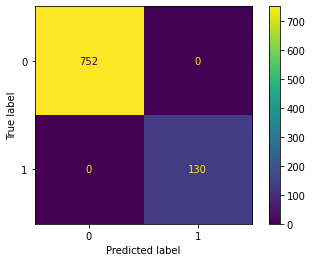

Logistic Regression


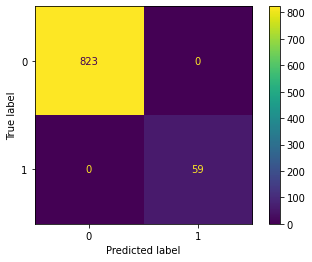

Multi Layered Perceptron


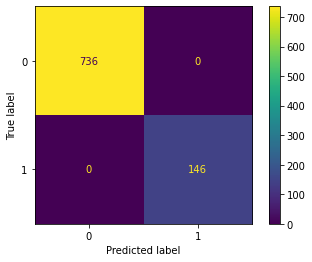

In [21]:
from sklearn import metrics 

for name, model in model_dict.items():
    print(name)
    metrics.plot_confusion_matrix(model, X_test, y_pred_dict[name])  
    plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score, average_precision_score, f1_score, fbeta_score


def printscore(model, y_pred):
    global X_test, y_test
    #Score of our classifier
    print('  Classifier Score :', model.score(X_test, y_test))

    #Precision of our score
    print('  Precision Score :', precision_score(y_test, y_pred))

    # Recall of our score
    print('  Recall Score : ', recall_score(y_test, y_pred))

    # Score of the average precision
    print('  Average Precision Score : ', average_precision_score(y_test, y_pred))

    # F1 Score
    print('  F1 Score : ', f1_score(y_test, y_pred))

    # F Beta Score
    print('  F Beta Score : ', fbeta_score(y_test, y_pred, beta= 0.5))

for name, model in model_dict.items():
    print(f"\nModel name: {name}")
    printscore(model, y_pred_dict[name])


Model name: Random Forest
  Classifier Score : 0.9829931972789115
  Precision Score : 1.0
  Recall Score :  0.896551724137931
  Average Precision Score :  0.9135585268590195
  F1 Score :  0.9454545454545454
  F Beta Score :  0.9774436090225563

Model name: Logistic Regression
  Classifier Score : 0.8503401360544217
  Precision Score : 0.6101694915254238
  Recall Score :  0.2482758620689655
  Average Precision Score :  0.2750731229565662
  F1 Score :  0.35294117647058826
  F Beta Score :  0.47244094488188987

Model name: Multi Layered Perceptron
  Classifier Score : 0.9897959183673469
  Precision Score : 0.9657534246575342
  Recall Score :  0.9724137931034482
  Average Precision Score :  0.9436470982661682
  F1 Score :  0.9690721649484535
  F Beta Score :  0.9670781893004115


Cross validation

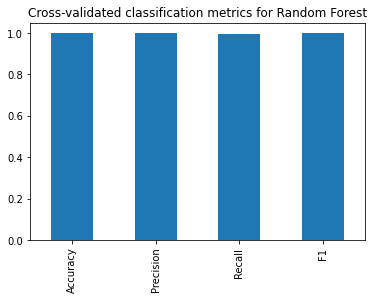

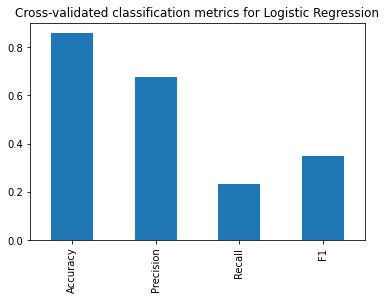

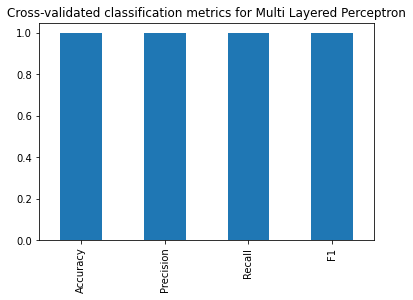

In [24]:
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

for i, modelnname  in enumerate([(k, v) for k, v in model_dict.items()]):
    classifier_acc = cross_val_score(modelnname[1], X, y, cv = 5, scoring="accuracy")
    classifier_precision = cross_val_score(modelnname[1], X, y, cv = 5, scoring="precision")
    classifier_recall = cross_val_score(modelnname[1], X, y, cv = 5, scoring="recall")
    classifier_f1 = cross_val_score(modelnname[1], X, y, cv=5, scoring="f1")

    classifier_acc, classifier_precision, classifier_recall, classifier_f1

    classifierMetrics = pd.DataFrame({
        "Accuracy": np.mean(classifier_acc),
        "Precision": np.mean(classifier_precision),
        "Recall": np.mean(classifier_recall),
        "F1": np.mean(classifier_f1)}, index=[0])

    classifierMetrics.T.plot.bar(
        title=f"Cross-validated classification metrics for {modelnname[0]}",
        legend=False)

Graphes


>- Model Name Random Forest

Precision recall curve


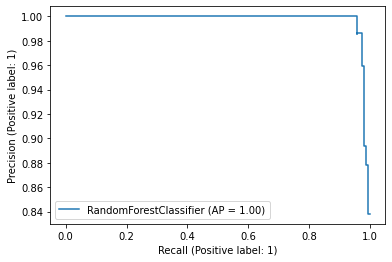

Receiver Operating Characteristic Curve


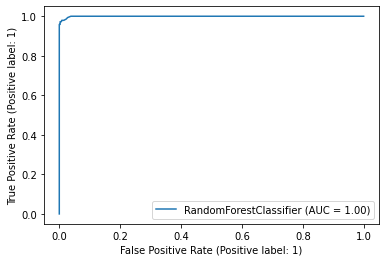

Detection error tradeoff curve


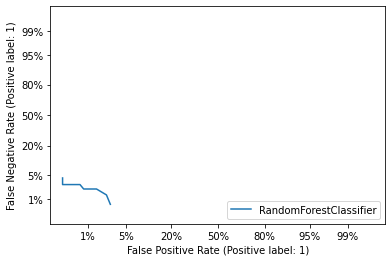

Learning Curve


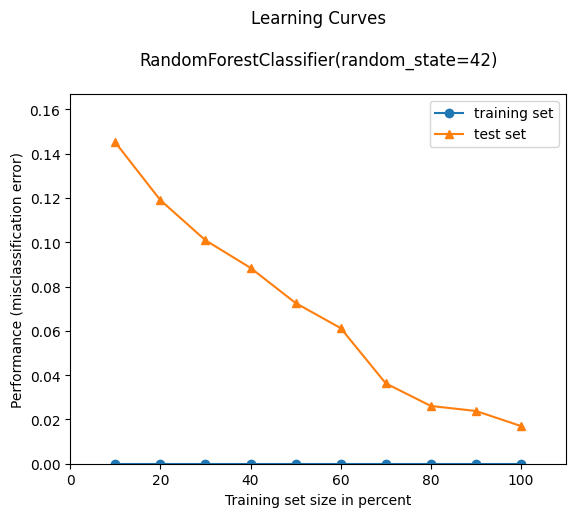


>- Model Name Logistic Regression

Precision recall curve


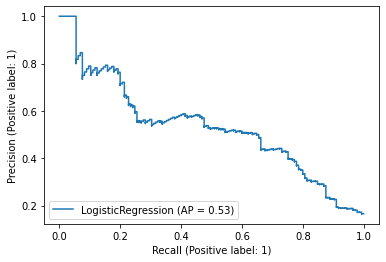

Receiver Operating Characteristic Curve


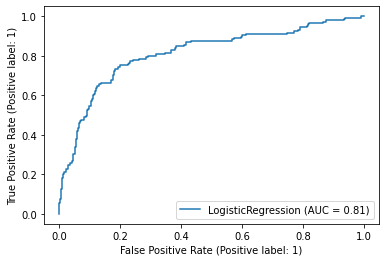

Detection error tradeoff curve


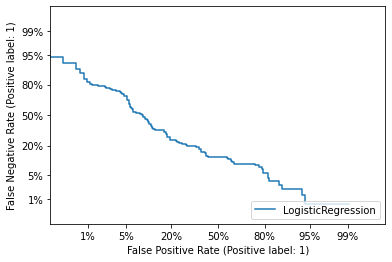

Learning Curve


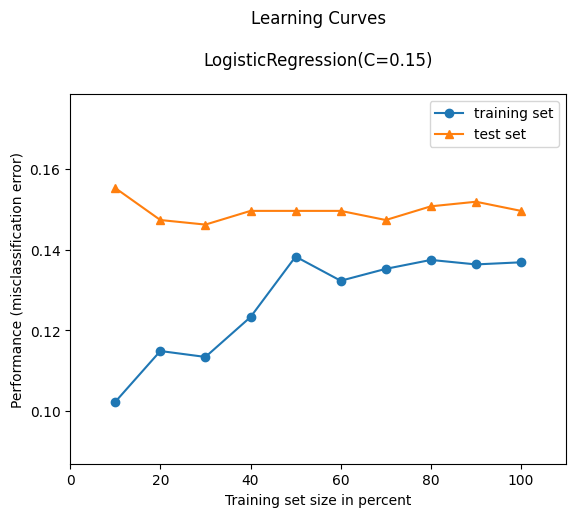


>- Model Name Multi Layered Perceptron

Precision recall curve


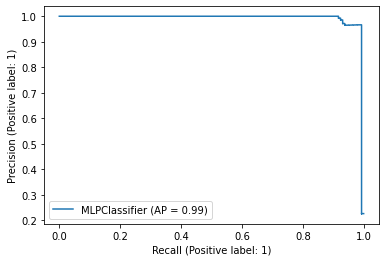

Receiver Operating Characteristic Curve


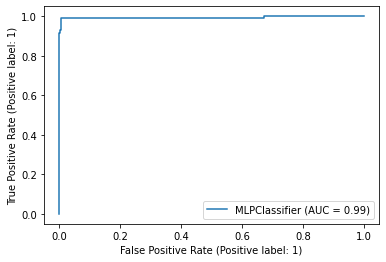

Detection error tradeoff curve


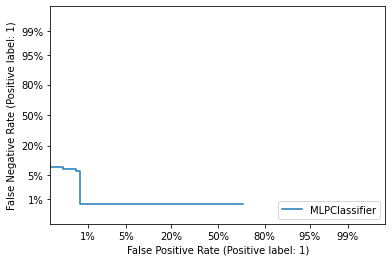

Learning Curve


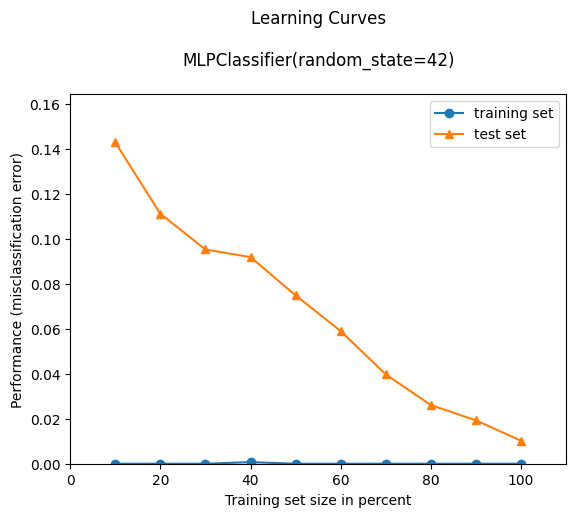

In [25]:
from mlxtend.plotting import plot_learning_curves

for name, model in model_dict.items():

    print(f"\n>- Model Name {name}\n")

    print('Precision recall curve')
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    plt.show()

    print('Receiver Operating Characteristic Curve')
    metrics.plot_roc_curve(model, X_test, y_test)
    plt.show()

    print('Detection error tradeoff curve')
    metrics.plot_det_curve(model, X_test, y_test)
    plt.show()

    print('Learning Curve')
    plot_learning_curves(X_train, y_train, X_test, y_test, model)
    plt.show()
